In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt

tSI_data = genfromtxt('tSI_data.csv', delimiter=',') #in the form of [t, S, I]
tao_data = genfromtxt('tao_data.csv', delimiter=',') #in the form of [t, tao_star, T_star, us]


starting training...

epoch:  0
self.alpha1 tensor([0.4899], requires_grad=True)
loss:  tensor(36250.0977, grad_fn=<AddBackward0>)

epoch:  1
self.alpha1 tensor([0.4899], requires_grad=True)
loss:  tensor(8870.6924, grad_fn=<AddBackward0>)

epoch:  2
self.alpha1 tensor([0.4899], requires_grad=True)
loss:  tensor(16109.9521, grad_fn=<AddBackward0>)

epoch:  3
self.alpha1 tensor([0.4899], requires_grad=True)
loss:  tensor(7832.4229, grad_fn=<AddBackward0>)

epoch:  4
self.alpha1 tensor([0.4899], requires_grad=True)
loss:  tensor(25928.8281, grad_fn=<AddBackward0>)

epoch:  5
self.alpha1 tensor([0.4899], requires_grad=True)
loss:  tensor(9113.4316, grad_fn=<AddBackward0>)

epoch:  6
self.alpha1 tensor([0.4899], requires_grad=True)
loss:  tensor(509444.7500, grad_fn=<AddBackward0>)

epoch:  7
self.alpha1 tensor([0.4899], requires_grad=True)
loss:  tensor(78206.3438, grad_fn=<AddBackward0>)

epoch:  8
self.alpha1 tensor([0.4899], requires_grad=True)
loss:  tensor(7973.6929, grad_fn=<AddBac

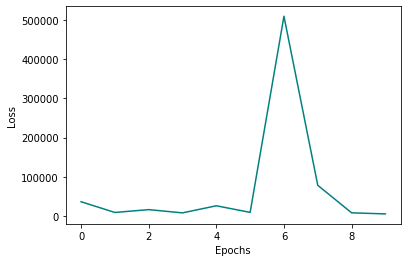

In [5]:
class DINN:
    def __init__(self, t, S_data, I_data, tao_data, T_star_data, u_data): #, t, S_data, I_data, tao_data, T_star_data, u
        self.t = t
        self.S = S_data
        self.I = I_data
        self.taos = tao_data
        self.T_stars = T_star_data
        self.u_data = u_data

        #data 
        #self.tu = #combine t, u 

        #NN
        self.nx = self.net_x()
        self.lr =  0.01
        self.momentum = 0.5      
        self.optimizer = optim.SGD(self.nx.parameters(), lr = self.lr, momentum = self.momentum)

        #predictions
        self.S_pred, self.I_pred, self.tao_pred, self.T_star_pred = self.nx(self.t_u) #fix t_u
        self.f1, self.f2 = self.net_f(self.t_u) #fix t_u

        #loss
        self.loss = (torch.mean(torch.square(self.S-self.S_pred))+torch.mean(torch.square(self.I-self.I_pred)) \
                    + #S,I 
                    torch.mean(torch.square(self.f1)) + torch.mean(torch.square(self.f2)) \
                    + #f1, f2
                    torch.mean(torch.square(self.taos-self.tao_pred)) + torch.mean(torch.square(self.T_stars-self.T_star_pred))) #tao, T_star

        #learnable parameters
        self.alpha1=torch.rand(1, requires_grad=True)
        self.alpha2=torch.rand(1, requires_grad=True)
        self.mu=torch.rand(1, requires_grad=True)
        self.beta=torch.rand(1, requires_grad=True)

    #nets
    class net_x(nn.Module): # input = [t, u]
        def __init__(self):
            super(DINN.net_x, self).__init__()
            self.fc1=nn.Linear(2, 20) #takes t, u
            self.fc2=nn.Linear(20, 20)
            self.out=nn.Linear(20, 4) #outputs S, I, tao, T*

        def forward(self, x):
            x=self.fc1(x)
            x=self.fc2(x)
            x=self.out(x)
            return x    
    
    
    def net_f(self, t, u):        
        S_t = grad(self.S_pred, t_u, retain_graph=True)[0][0] #derivative of S_pred wrt t              
        I_t = grad(self.I_pred, t_u, retain_graph=True)[0][0] #derivative of I_pred wrt t              
        
        f1 = S_t + self.beta * self.S * self.I + self.u * (t > tao) * self.alpha1
        f2 = I_t - self.beta * S * I + self.mu * I + u * (t > tao) * self.alpha2

        return f1, f2
    
        
    def train(self, n_epochs):
        print('\nstarting training...\n')
        losses = []
        learning_rate = 0.01
        momentum = 0.5        
        
        optimizer = optim.SGD(self.nx.parameters(), lr = learning_rate, momentum = momentum)

        for epoch in range(n_epochs):
            print('epoch: ', epoch)
            print('self.alpha1', self.alpha1)
            #print('self.alpha2', self.alpha2)
            for time_step in range(len(self.t)):
                optimizer.zero_grad()

                t_value, u_value = self.t[time_step], self.u_data[time_step]
                t_value = torch.tensor(t_value)
                u_value = torch.tensor(u_value)

                f1, f2 = self.net_f(t_value, u_value)
                #print('f1, f2: ', f1, f2)
                t_u = torch.tensor([t_value.float(), u_value.float()], requires_grad = True)
                #print('t_u: ', t_u)
                S_pred, I_pred, tao_pred, T_star_pred = self.nx(t_u)
                #print('S_pred, I_pred, tao_pred, T_star_pred: ', S_pred, I_pred, tao_pred, T_star_pred)
                loss = (torch.mean(torch.square(self.S[time_step]-S_pred))+torch.mean(torch.square(self.I[time_step]-I_pred)) \
                    + #S,I 
                    torch.mean(torch.square(f1)) + torch.mean(torch.square(f2)) \
                    + #f1, f2
                    torch.mean(torch.square(self.taos[time_step]-tao_pred)) + torch.mean(torch.square(self.T_stars[time_step]-T_star_pred))) #tao, T_star
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.nx.parameters(), 100) #gradient clipping
                optimizer.step()

            losses.append(loss)    
            print('loss: ', losses[-1])
            print('')
        plt.plot(losses, color = 'teal')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

dinn = DINN(tSI_data[0], tSI_data[1], tSI_data[2], tao_data[1], tao_data[2], tao_data[3]) #t, S_data, I_data, tao_data, T_star_data, u
dinn.train(10)        

In [10]:
tSI_data[0] #t
tao_data[3] #u

(100,)

In [15]:
a = torch.ones(100)
b = torch.zeros(100)


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])